In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Process"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| output: false
#| echo: false
using Plots

function plot_2dtraj(traj; title="ZigZag Sampler", save=false, label="ZigZag_2D")
    # trajからx座標とy座標を抽出
    x_coords = [state[1] for (t, state) in traj]
    y_coords = [state[2] for (t, state) in traj]

    # 軌跡のプロット
    p = plot(x_coords, y_coords, 
             label=label,
             title=title,
             xlabel="X",
             ylabel="Y",
             linewidth=2,
             marker=:circle,
             markersize=2,
             markeralpha=0.6,
             color="#78C2AD"
             #,background_color = "#F0F1EB"
             )

    # 開始点と終了点をマーク
    Plots.scatter!([x_coords[1]], [y_coords[1]], label="Start", color=:green, markersize=6)
    Plots.scatter!([x_coords[end]], [y_coords[end]], label="End", color=:red, markersize=6)

    # プロットを表示
    display(p)

    if save
        savefig(p, label * ".svg")
    end
    
end

function plot_1dtraj(traj; title="ZigZag Sampler", markersize=2, save=false, label="ZigZag_1D", ylim=nothing)
    times = [t for (t, state) in traj]
    positions = [state[1] for (t, state) in traj]

    # 軌跡のプロット
    plot_args = (
    label=label,
    title=title,
    xlabel="t",
    ylabel="X",
    linewidth=2,
    marker=:circle,
    markersize=markersize,
    markeralpha=0.6,
    color="#78C2AD"
    #,background_color = "#F0F1EB"
    )

    if ylim !== nothing
        plot_args = merge(plot_args, (ylim=ylim,))
    end

    p = plot(times, positions; plot_args...)

    if save
        savefig(p, label * ".svg")
    end

    return p
end

plot_1dtraj (generic function with 1 method)

In [3]:
#| code-fold: true
#| echo: false
#| output: false
using ZigZagBoomerang
const ZZB = ZigZagBoomerang

"""
    τ = freezing_time(x, θ)

computes the hitting time of a 1d particle with
constant velocity `θ` to hit 0 given the position `x`
"""
function freezing_time(x, θ)
    if θ*x > 0
        return Inf
    else
        return -x/θ
    end
end

"""
    T: Time Horizon
    (x,θ): initial state
    ∇U: gradient of the negative log-density
    c: tuning parameter
    k: weight on the Dirac measure
"""
# k determines the weight on the Dirac measure. The smaller k, the higher the wegiht
function ss_pdmp(∇U, x, θ, T, c, k, Flow::ZZB.ContinuousDynamics; adapt=false, factor=2.0, rng=Random.GLOBAL_RNG)
    t = zero(T)
    Ξ = [(t, x, θ)]
    num = acc = 0
    a, b = ZZB.ab(x, θ, c, Flow)
    t_ref = t + ZZB.waiting_time_ref(Flow)
    t′ =  t + poisson_time(a, b, rand(rng))
    tˣ = t + freezing_time(x, θ)
    while t < T
        if  tˣ < min(t_ref, t′)
            t, x, θ = ZZB.move_forward(tˣ - t, t, x, θ, Flow) # go to 0
            @assert -0.0001 < x < 0.0001 #check
            #t, x , θ = tˣ, 0.0, θ #go to 0
            push!(Ξ, (t, x, 0.0))
            t = t - log(rand(rng))/k #wait exponential time
            push!(Ξ, (t, x, θ))
            tˣ  = Inf
        elseif t_ref < t′
            t, x, θ = ZZB.move_forward(t_ref - t, t, x, θ, Flow)
            θ = sqrt(Flow.Σ)*randn(rng)
            t_ref = t +  ZZB.waiting_time_ref(Flow)
            tˣ = t + freezing_time(x, θ)
            push!(Ξ, (t, x, θ))
        else
            τ = t′ - t
            t, x, θ = ZZB.move_forward(τ, t, x, θ, Flow)
            l, lb = ZZB.λ(∇U, x, θ, Flow), ZZB.λ_bar(τ, a, b)
            num += 1
            if rand(rng)*lb < l
                acc += 1
                if l >= lb
                    !adapt && error("Tuning parameter `c` too small.")
                    c *= factor
                end
                θ = -θ  # In multi dimensions the change of velocity is different:
                        # reflection symmetric on the normal vector of the contour
                tˣ = t + freezing_time(x, θ)
                push!(Ξ, (t, x, θ))
            end
        end
        a, b = ZZB.ab(x, θ, c, Flow)
        t′ = t + poisson_time(a, b, rand(rng))
    end
    return Ξ, acc/num
end

ss_pdmp (generic function with 1 method)

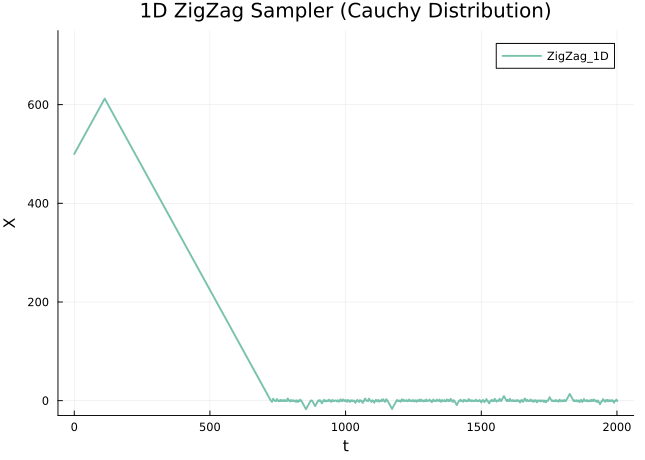

In [4]:
#| code-fold: true
#| echo: false
#| fig-cap: "\rC(0,1) に対する ZigZag サンプラーの軌道"
#| #| fig-label: fig-ZigZag
using ZigZagBoomerang
using LinearAlgebra
using SparseArrays
using Plots
using RandomNumbers.Xorshifts

rng = Xoroshiro128Plus(2022)

# C(0,1) 分布のポテンシャル関数（使わない）
U(x) = log(1 + x^2)

# ポテンシャル関数の勾配
∇U(x) = 2x / (1 + x^2)

# 初期値
x0 = 500.0
θ0 = 1.0

T = 2000.0  # 総シミュレーション時間

# ZigZag過程の設定
Z = ZigZag1d()

# リジェクションバウンド（必要に応じて調整）
c = 1.0

k = 1.0

# ZigZag過程の実行
trace, acc = ss_pdmp(∇U, x0, θ0, T, c, k, Z; rng=rng)

# 軌跡の離散化とサンプリング
# dt = 0.1
# traj = collect(ZigZagBoomerang.discretize(trace, dt))

traj = [(x[1], x[2]) for x in trace]

# サンプルの表示

p1 = plot_1dtraj(traj, title="1D ZigZag Sampler (Cauchy Distribution)", markersize=0, ylim=(-30, 750), label="ZigZag_1D")

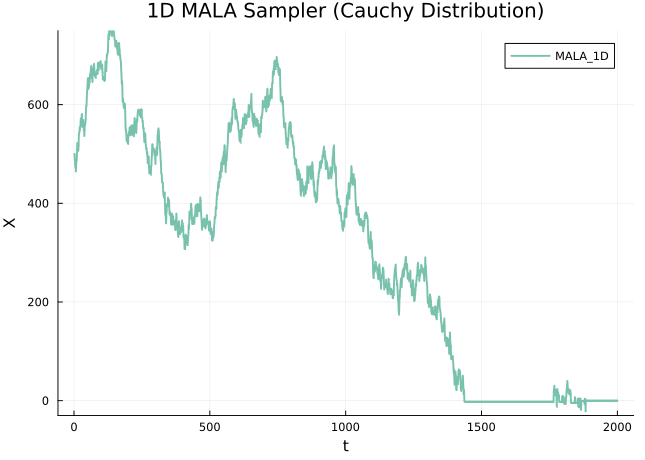

In [5]:
#| code-fold: true
#| fig-cap: "\rC(0,1) に対する MALA サンプラーの軌道"
using AdvancedHMC, AdvancedMH, ForwardDiff
using LinearAlgebra
using LogDensityProblems
using LogDensityProblemsAD
using StructArrays
using Distributions
using Random

Random.seed!(2)

# Define the target distribution (1D Cauchy) using the `LogDensityProblem` interface
struct LogTargetDensityCauchy
    loc::Float64
    scale::Float64
end

LogDensityProblems.logdensity(p::LogTargetDensityCauchy, θ) = -log(π) - log(p.scale) - log(1 + ((θ[1] - p.loc)/p.scale)^2)
LogDensityProblems.dimension(p::LogTargetDensityCauchy) = 1
LogDensityProblems.capabilities(::Type{LogTargetDensityCauchy}) = LogDensityProblems.LogDensityOrder{0}()

# Choose initial parameter value for 1D
initial_θ = [500.0]

# Use automatic differentiation to compute gradients
model_with_ad = LogDensityProblemsAD.ADgradient(Val(:ForwardDiff), LogTargetDensityCauchy(0.0, 1.0))

# Set up the sampler with a multivariate Gaussian proposal.
σ² = 100
spl = MALA(x -> MvNormal((σ² / 2) .* x, σ² * I))

# Sample from the posterior.
chain = sample(model_with_ad, spl, 2000; initial_params=initial_θ, chain_type=StructArray, param_names=["θ"])

# plot
θ_vector = chain.θ
sample_values = zip(1:length(θ_vector), θ_vector)
p2 = plot_1dtraj(sample_values, title="1D MALA Sampler (Cauchy Distribution)", markersize=0, ylim=(-30, 750), label="MALA_1D")

In [6]:
#| echo: false
#| output: false

# Define the Cauchy distribution with location and scale
loc, scale = 0.0, 1.0
ℓπ = LogTargetDensityCauchy(loc, scale)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 2000, 0

# Define a Hamiltonian system
metric = DiagEuclideanMetric(1)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with the initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = Leapfrog(initial_ϵ)

# Define an HMC sampler with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

# Run the sampler to draw samples from the specified Cauchy distribution, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples, stats = sample(hamiltonian, kernel, initial_θ, n_samples, adaptor, n_adapts; progress=true)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/kVZZH/src/ProgressMeter.jl:594
Sampling 100%|███████████████████████████████| Time: 0:00:00
  iterations:                                   2000
  ratio_divergent_transitions:                  0.02
  ratio_divergent_transitions_during_adaption:  0.0
  n_steps:                                      1
  is_accept:                                    true
  acceptance_rate:                              2.863469784959107e-17
  log_density:                                  -15.86419320804587
  hamiltonian_energy:                           15.864286021695538
  hamiltonian_energy_error:                     0.0
  max_hamiltonian_energy_e

┌ Info: Finished 2000 sampling steps for 1 chains in 0.827598667 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=1640.0), tc=GeneralisedNoUTurn{Float64}(10, 1000.0)))
│   EBFMI_est = 0.3245110367226575
└   average_acceptance_rate = 0.2537609789148177


([[500.0], [500.0], [-1490.9425976095117], [1239.660000937718], [1419.1057953677991], [1952.9704516433658], [1952.9704516433658], [-413.3050126275907], [-413.3050126275907], [-413.3050126275907]  …  [-1046.117968392255], [19260.19698383325], [7526.906939043931], [2509.1642162114567], [2509.1642162114567], [2976.1795637021214], [1752.1425652670162], [-1571.4145164616164], [-1571.4145164616164], [-1571.4145164616164]], NamedTuple[(n_steps = 1, is_accept = true, acceptance_rate = 0.0026437363189432904, log_density = -13.573950082685784, hamiltonian_energy = 13.83908561450436, hamiltonian_energy_error = 0.0, max_hamiltonian_energy_error = 5.935562090050862, tree_depth = 1, numerical_error = false, step_size = 1638.4, nom_step_size = 1638.4, is_adapt = false), (n_steps = 1, is_accept = true, acceptance_rate = 0.00027882999271169586, log_density = -13.573950082685784, hamiltonian_energy = 13.589073219813551, hamiltonian_energy_error = 0.0, max_hamiltonian_energy_error = 8.184908306988467, tr

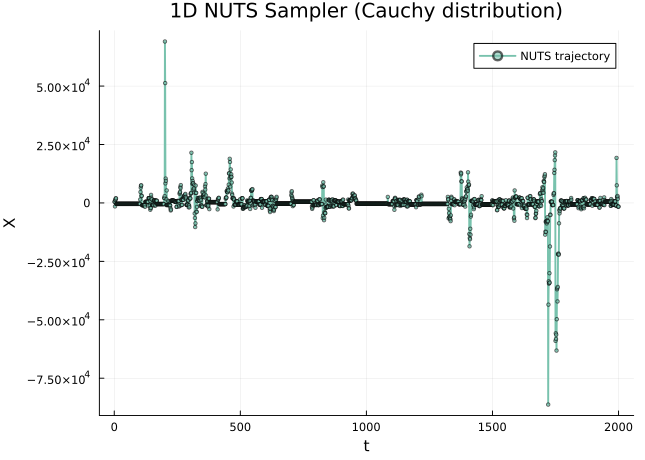

In [7]:
#| echo: false
#| fig-cap: "\rC(0,1) に対する NUTS サンプラーの軌道"
using Plots

sample_values = [s[1] for s in samples]
p = plot(1:length(samples), sample_values,
             label="NUTS trajectory",
             title="1D NUTS Sampler (Cauchy distribution)",
             xlabel="t",
             ylabel="X",
             linewidth=2,
             marker=:circle,
             markersize=2,
             markeralpha=0.6,
             color="#78C2AD")

In [8]:
#| output: false
using ZigZagBoomerang
using SparseArrays

d = 2

# 対数尤度関数 ϕ の第 i 成分に関する微分を計算
Γ = sparse([1,1,2,2], [1,2,1,2], [2.0,-1.0,-1.0,2.0])  # <1>
∇ϕ(x, i, Γ) = ZigZagBoomerang.idot(Γ, i, x)  # <2>

# 初期値
t0 = 0.0
x0 = randn(d)
θ0 = rand([-1.0,1.0], d)

# Rejection bounds
c = 1.0 * ones(length(x0))

# ZigZag 過程をインスタンス化
Z = ZigZag(Γ, x0*0)

# シミュレーション実行
T = 20.0
zigzag_trace, (tT, xT, θT), (acc, num) = spdmp(∇ϕ, t0, x0, θ0, T, c, Z, Γ; adapt=true)

# 軌跡を離散化
traj = collect(zigzag_trace)

25-element Vector{Pair{Float64, Vector{Float64}}}:
                0.0 => [0.04255564345605987, -0.05142251166742789]
 0.7561677521781738 => [-0.7136121087221139, -0.8075902638456016]
 1.6147677990914207 => [-1.5722121556353608, 0.051009783067645253]
 2.1315047797735587 => [-1.0554751749532227, 0.5677467637497833]
 3.4218287330830797 => [0.23484877835629825, -0.7225771895597377]
 3.6495442341401767 => [0.4625642794133953, -0.4948616885026407]
  4.697809534373489 => [-0.5857010208199169, 0.5534036117306715]
  5.838511112737461 => [0.5550005575440549, 1.6941051900946433]
  6.943669440374271 => [1.6601588851808653, 0.5889468624578329]
   7.43422150080481 => [1.1696068247503264, 0.098394802027294]
  8.660592270864283 => [-0.05676394530914686, 1.3247655720867673]
  9.338317770684316 => [-0.7344894451291799, 0.6470400722667342]
  10.78958636179614 => [0.7167791459826434, -0.8042285188450891]
 10.794812841045992 => [0.7115526667327907, -0.8094549980949417]
 11.973940913447297 => [-0.467575405

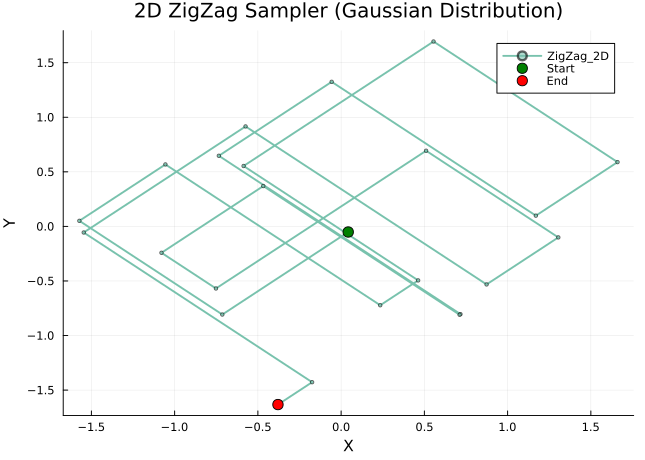

In [9]:
#| echo: false
plot_2dtraj(traj, title="2D ZigZag Sampler (Gaussian Distribution)"; label="ZigZag_2D")